In [8]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
plt.interactive(False)
import tensorflow as tf
import h5py
from scipy.stats import pearsonr
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers, callbacks, regularizers, initializers
from E2E_conv import *
import numpy as np
from vis.visualization import visualize_activation
from keras.utils import to_categorical
from nilearn import datasets
from nilearn import input_data
from nilearn.connectome import ConnectivityMeasure
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

Setting up the hyper parameters, and l2 regularizer




In [2]:
# Globals : Hyperparamaters
batch_size = 14
dropout = 0.5
momentum = 0.9
noise_weight = 0.0625
lr = 0.01
decay = 0.0005

# Setting l2_norm regularizer
reg = regularizers.l2(decay)
kernel_init = initializers.he_uniform()

the synthetic connectome is represented as a graph $G(A,\Omega)$ where : <br> 
- $\Omega$ is the set of nodes each node represents a region of the brain.
- $ A $ is the weighted adjency matrix of the adges representing the strength of the connections between the regions.

## Constructing the new layers
### E2E layer 
$$ A^{l+1,n}_{i,j} = \sum_{k=1}^{|\Omega|} \sum_{m=1}^{M^{l}}[ r_k^{l,m,n}A_{i,k}^{l,m} +   c_k^{l,m,n}A_{k,j}^{l,m}] $$
To construct this layer, we must create two kernels corresponding to r and c of size $1x|\Omega|$ and $|\Omega|x1$ respectively, we then convolve with the output filters, duplicate them $|\Omega|$ times than sum the duplications elementwize to create the convolution discribed above.

To use the layer, simply do:

In [3]:
from E2E_conv import *

### E2N layer 
$$a^{l+1,n}_i = \sum_{k=1}^{|\Omega|} \sum_{m=1}^{M^{l}}[ r_k^{l,m,n}A_{i,k}^{l,m} +   c_k^{l,m,n}A_{k,i}^{l,m}]$$
A simple 1-D convolution. Code in model architecture 

### E2N layer 
$$ a^{l+1,n} = \sum_{k=1}^{|\Omega|} \sum_{m=1}^{M^{l}} w_k^{l,m,n}a_{i}^{l,m}$$
A simple 1-D convolution. Code in model architecture 

## Creating the model
### Description :
![alt text](screen1.png "Description of the different layers")
l2_regularization was introduced in every layer. 
Dropout of 0.5 was introduced for every layer after N2G layer.
The Activation uses very leaky rectified linear units '$\alpha=0.33$'.


## Verifying the visualization methode using Keras-vis "Activation-Maximization"

### generating synthetic data

The functions in the generate_synth_injury file generate synthetic connectomes with injuries introduced at a specific region, the injury affects all the connections spreading from the region with different intensities (based on the functions from Amine Echraibi [here](https://github.com/AmineEch/BrainCNN/blob/master/BrainNetCNN.ipynb), which are a modification of the opensource implementation using Caffe described [Here](https://github.com/jeremykawahara/ann4brains)

In [9]:
from generate_synth_injury import *

In [10]:
from importlib import reload

In [11]:
reload(generate_synth_injury)

<module 'generate_synth_injury' from '/Users/nicolasfarrugia/Documents/recherche/git/BrainCNN_vis/generate_synth_injury.py'>

## Using Adhd data for visualization


in this section we will use adhd data collected from nilearn database to construct a mean connectome of the control patients, than we will use this mean connectome to generate the phantom dataset with injuries introduced at specific regions.

### Downloading data

In [5]:
adhd_data = datasets.fetch_adhd(n_subjects=1)
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords

masker = input_data.NiftiMapsMasker(
    msdl_data.maps, resampling_target="data", t_r=2.5, detrend=True,
    low_pass=.1, high_pass=.01, memory='nilearn_cache', memory_level=1)
adhd_subjects = []
pooled_subjects = []
site_names = []
adhd_labels = []  # 1 if ADHD, 0 if control
for func_file, confound_file, phenotypic in zip(
        adhd_data.func, adhd_data.confounds, adhd_data.phenotypic):
    time_series = masker.fit_transform(func_file, confounds=confound_file)
    pooled_subjects.append(time_series)
    is_adhd = phenotypic['adhd']
    if is_adhd:
        adhd_subjects.append(time_series)

    site_names.append(phenotypic['site'])
    adhd_labels.append(is_adhd)

conn_measure = ConnectivityMeasure(kind="tangent")
X = conn_measure.fit_transform(pooled_subjects)
Y = np.array(adhd_labels,dtype="float32")

/Users/nicolasfarrugia/miniconda3/envs/tf/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### Setting up the network architecture

the phantom data genetated is constructed from the mean connectome of the control patients from adhd dataset, we generate two classes of injuries each at a specific region, than the BrainNetCNN is trained to detect each class. finaly we use keras-vis "maximization-activation" to genrate connectomes maximizing the classification score.


In [6]:
# Hyper parameters

batch_size = 14
dropout = 0.5
momentum = 0.9
lr = 0.001
decay = 0.0005
noise_weight = 0.0625

reg = regularizers.l2(decay)
kernel_init = initializers.he_uniform()

# Model architecture


model = Sequential()
model.add(E2E_conv(2,8,(2,39),kernel_regularizer=reg,input_shape=(39,39,1),input_dtype='float32',data_format="channels_last"))
print("First layer output shape :"+str(model.output_shape))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(3,(1,39),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
model.add(Convolution2D(90,(39,1),kernel_regularizer=reg,data_format="channels_last"))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(64,kernel_regularizer=reg,kernel_initializer=kernel_init))
#print(model.output_shape)
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(10,kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(LeakyReLU(alpha=0.33))
#print(model.output_shape)
model.add(Dropout(0.5))
model.add(Dense(2,activation = "softmax",kernel_regularizer=reg,kernel_initializer=kernel_init))
model.add(Flatten())
model.summary()
#print(model.output_shape)


opt = optimizers.SGD(nesterov=True,lr=lr)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
csv_logger = callbacks.CSVLogger('predict_age.log')

kernel_shape : (2, 39, 1, 8)
data shape : (?, 39, 39, 1)
(1, 39, 1, 8)
(39, 1, 1, 8)
cat1(?, 39, 39, 8)
cat2<dtype: 'float32'>
First layer output shape :(None, 39, 39, 8)
(None, 39, 39, 8)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e2e_conv_1 (E2E_conv)        (None, 39, 39, 8)         624       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 39, 39, 8)         0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 39, 39, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 1, 3)          939       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 39, 1, 3)          0         
_________________________________________________________________
conv2d_2 (Conv2D)  

In [12]:
# Generating the two classes injury introduced at node 5 and 30
r_state = np.random.RandomState(41)
base_connectome = conn_measure.mean_
base_connectome = (base_connectome.T + base_connectome)/2
S = generate_injury_signatures(X_mn=base_connectome,r_state=r_state,sig_indexes=[5])
X1,Y = sample_injury_strengths(1000,base_connectome,S,noise_weight)
S = generate_injury_signatures(X_mn=base_connectome,r_state=r_state,sig_indexes=[30])
X2,Y = sample_injury_strengths(1000,base_connectome,S,noise_weight)

In [13]:
# Constructing the dataset
X = np.concatenate([X1,X2],axis=0)
X = X.reshape(X.shape[0],X.shape[2],X.shape[3],1)
Y1 = np.array([1]*1000)
Y2 = np.array([0]*1000)
Y = np.concatenate([Y1,Y2],axis=0)
Y = to_categorical(Y,2)
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.33,random_state=42)

In [15]:
# fitting the model 
train = str(input("train/predict enter 1/0"))
if train =="1" :
    model.fit(x_train,y_train,batch_size=14,epochs=10,verbose=1,callbacks=[csv_logger])
    model.save_weights("BrainCNNWeights_Visualization.h5")
else :
    model.load_weights("BrainCNNWeights_Visualization.h5")
    evals = model.evaluate(batch_size=14,x=x_test,y=y_test)
    print(evals)

train/predict enter 1/01
Epoch 1/10
1340/1340 [==============================] - 1s - loss: 0.7717 - acc: 0.5642     
Epoch 2/10
1340/1340 [==============================] - 1s - loss: 0.7721 - acc: 0.5463     
Epoch 3/10
1340/1340 [==============================] - 1s - loss: 0.7709 - acc: 0.5724     
Epoch 4/10
1340/1340 [==============================] - 1s - loss: 0.7702 - acc: 0.5701     
Epoch 5/10
1340/1340 [==============================] - 1s - loss: 0.7714 - acc: 0.5522     
Epoch 6/10
1340/1340 [==============================] - 1s - loss: 0.7704 - acc: 0.5828     
Epoch 7/10
1340/1340 [==============================] - 1s - loss: 0.7706 - acc: 0.5716     
Epoch 8/10
1340/1340 [==============================] - 1s - loss: 0.7701 - acc: 0.5843     
Epoch 9/10
1340/1340 [==============================] - 1s - loss: 0.7686 - acc: 0.5955     
Epoch 10/10
1340/1340 [==============================] - 1s - loss: 0.7685 - acc: 0.5993     


/Users/nicolasfarrugia/miniconda3/envs/tf/lib/python3.6/site-packages/nilearn/plotting/displays.py:1291: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


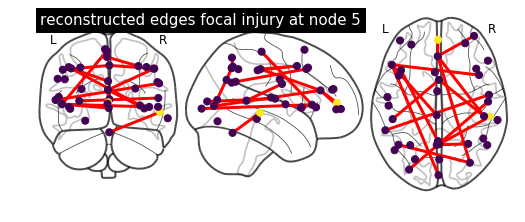

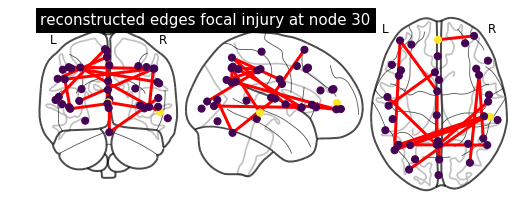

In [16]:
# plotting results for generated connectomes using maximization-activation
from nilearn import plotting
%matplotlib inline
x = np.zeros((39))
x[5] = 1
x[30] = 1
heatmap1 = visualize_activation(model,layer_idx=-1, filter_indices=1,input_range = (0.,0.1))[:,:,0]
heatmap0 = visualize_activation(model,layer_idx=-1, filter_indices=0,input_range = (0.,0.1))[:,:,0]
plotting.plot_connectome(heatmap1.T+heatmap1,msdl_coords,title="reconstructed edges focal injury at node 5",edge_threshold = '98%',node_color=x)
plotting.plot_connectome(heatmap0.T+heatmap0,msdl_coords,title="reconstructed edges focal injury at node 30",edge_threshold = '98%',node_color=x)


### Utility functions for automating scripts

/Users/nicolasfarrugia/miniconda3/envs/tf/lib/python3.6/site-packages/nilearn/plotting/displays.py:1291: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if node_color == 'auto':


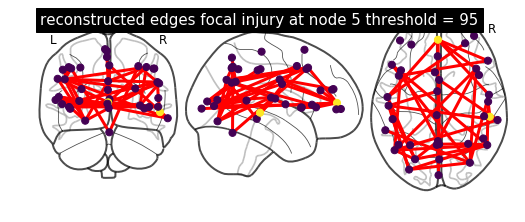

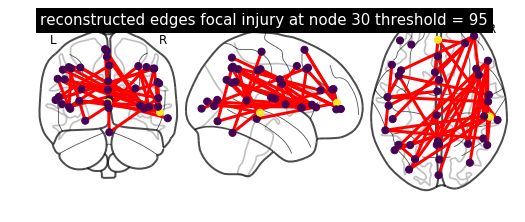

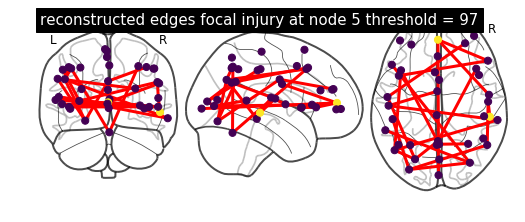

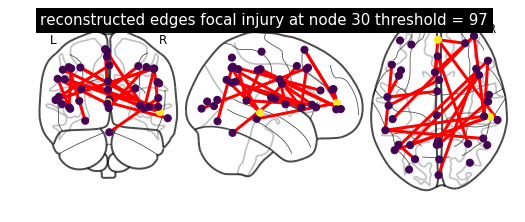

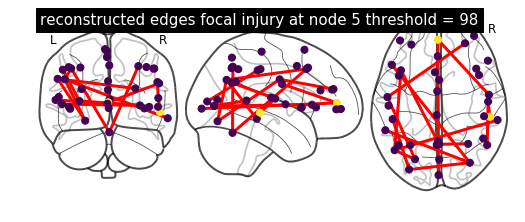

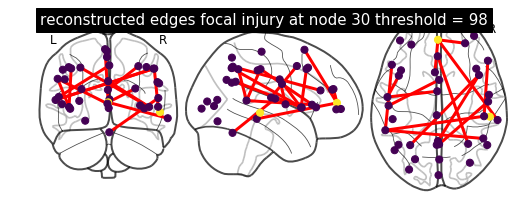

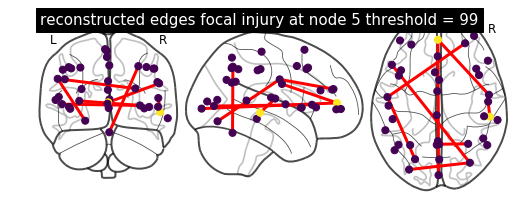

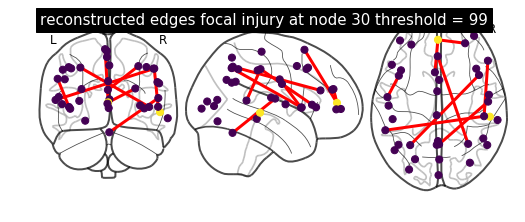

In [34]:
def plot_activation_maximization_result(model,first_injury_location,second_injury_location,thresholds):
    """
    model must be trained and the params first_injury_location and second_injury_location 
    must be the same as in the construct_dataset function.
    """
    from nilearn import plotting
    %matplotlib inline
    x = np.zeros((39))
    x[first_injury_location] = 1
    x[second_injury_location] = 1
    heatmap1 = visualize_activation(model,layer_idx=-1, filter_indices=1,input_range = (0.,0.1))[:,:,0]
    heatmap0 = visualize_activation(model,layer_idx=-1, filter_indices=0,input_range = (0.,0.1))[:,:,0]
    for t in thresholds :
        plotting.plot_connectome(heatmap1.T+heatmap1,msdl_coords,title="reconstructed edges focal injury at node "+str(first_injury_location)+" threshold = "+str(t),edge_threshold = str(t)+"%",node_color=x)
        plotting.plot_connectome(heatmap0.T+heatmap0,msdl_coords,title="reconstructed edges focal injury at node "+str(second_injury_location)+" threshold = "+str(t),edge_threshold =  str(t)+"%",node_color=x)
# example
plot_activation_maximization_result(model,5,30,[95,97,98,99])
   

(39, 1, 3, 90)
(39, 1, 3)
(39, 3)


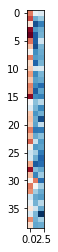

In [35]:
# Displaying the feature maps at the 5th layer
layer = model.layers[5]
weights = layer.get_weights()[0]
print(weights.shape)
from numpy.linalg import norm
image = norm(weights,axis = 3)
print(image.shape)
image = image.reshape(39,3)
print(image.shape)
plt.imshow(image,cmap='RdBu_r')